In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample
import io

In [3]:
dataset = pd.read_csv('/content/drive/My Drive/fer2013.csv')
#dataset = pd.read_csv('ferr2013.csv')
#(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

In [4]:
def convert_pixels_to_img(pixels):
    pixels = pixels/255
    test_image = pixels.reshape(48,48)

    return test_image

def split_pixels(string):
    splitted = np.array(string.split(),'int')
    return splitted 

def change_to_categorical(sample):
    return keras.utils.to_categorical(sample,num_classes=7)

def grayscale_to_rgb(grayscale_image): 
    rgb_image = np.stack((grayscale_image,)*3, axis=-1)
    return rgb_image 


In [5]:
dataset['pixels'] = dataset['pixels'].apply(split_pixels)
dataset['label'] = dataset['emotion'].apply(change_to_categorical)
dataset['length'] = dataset['pixels'].apply(len)

dataset = dataset[dataset.length == 2304]
dataset['image'] = dataset['pixels'].apply(convert_pixels_to_img)
dataset['image'] = dataset['image'].apply(grayscale_to_rgb)

In [6]:
emotion_labels = {0:'Angry', 1:'Disgust',2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

In [7]:
x = dataset.iloc[0]['image']
def int_to_emotion(x):
    return emotion_labels[x]

In [8]:
def get_distribution(data):
    emotion_count = data['emotion'].value_counts()
    emotion_count.index = emotion_count.index.map(int_to_emotion)
    print("Distribution count of emotions in the dataset:")
    print(emotion_count)
    print("")

get_distribution(dataset)

Distribution count of emotions in the dataset:
Happy       8989
Neutral     6198
Sad         6077
Fear        5121
Angry       4953
Surprise    4002
Disgust      547
Name: emotion, dtype: int64



In [9]:
dataset.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [10]:
dataset = dataset.loc[dataset["emotion"]!=1]
grouped_dataset = dataset.groupby(dataset.Usage)
training_dataset = grouped_dataset.get_group("Training")
dev_dataset = grouped_dataset.get_group("PublicTest")
test_dataset = grouped_dataset.get_group("PrivateTest")

get_distribution(training_dataset)
get_distribution(dev_dataset)
get_distribution(test_dataset)

Distribution count of emotions in the dataset:
Happy       7215
Neutral     4965
Sad         4830
Fear        4097
Angry       3995
Surprise    3171
Name: emotion, dtype: int64

Distribution count of emotions in the dataset:
Happy       895
Sad         653
Neutral     607
Fear        496
Angry       467
Surprise    415
Name: emotion, dtype: int64

Distribution count of emotions in the dataset:
Happy       879
Neutral     626
Sad         594
Fear        528
Angry       491
Surprise    416
Name: emotion, dtype: int64



In [11]:

def balancingDataset(data, x):
    new_df = data.loc[data['emotion']==x]
    data_to_add = 8000 - len(new_df)
    random_sampling = resample(new_df,random_state=42,replace=True,n_samples=data_to_add)
    return pd.concat([new_df,random_sampling])

df_0=balancingDataset(training_dataset,0)
df_2=balancingDataset(training_dataset,2)
df_3=balancingDataset(training_dataset,3)
df_4=balancingDataset(training_dataset,4)
df_5=balancingDataset(training_dataset,5)
df_6=balancingDataset(training_dataset,6)


training_dataset_aug=pd.concat([df_0,df_2,df_3,df_4,df_5,df_6])

# Pandas dataframe
x_train = training_dataset_aug['image']
y_train = training_dataset_aug['label']
x_test =  dev_dataset['image']
y_test = dev_dataset['label']

#Pandas dataframe to numpy
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

#numpy array reshape to fit into model
x_train = np.stack(x_train,axis=0)
y_train = np.stack(y_train,axis=0)
x_test = np.stack(x_test,axis=0)
y_test = np.stack(y_test,axis=0)


datagen = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        shear_range = 10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
generator=datagen.flow(x_train,y_train,batch_size=64)

In [12]:
get_distribution(training_dataset_aug)


Distribution count of emotions in the dataset:
Neutral     8000
Surprise    8000
Sad         8000
Happy       8000
Fear        8000
Angry       8000
Name: emotion, dtype: int64



In [13]:
from tensorflow.keras.applications.resnet50 import ResNet50

resnet50_model = ResNet50(weights='imagenet',input_shape=(48,48,3),include_top=False)

x = resnet50_model.output
x = layers.Flatten()(x)
x = layers.Dense(units=4096,activation='relu')(x)
x = layers.Dense(units=1024, activation='relu')(x)
x = layers.Dense(units=7, activation="softmax")(x)

new_model = keras.Model(inputs=resnet50_model.input, outputs=x)
for l in new_model.layers[:170]:
     l.trainable = False
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, mode='auto')
checkpointer = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/Emotion Recognition/Model/resnet50_sgd_freezed.h5', monitor='val_loss', verbose=1, save_best_only=True)


new_model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
from keras.preprocessing.image import ImageDataGenerator

history = new_model.fit(generator,batch_size=64,epochs=100,verbose=1,validation_data=(x_test, y_test),callbacks=[lr_reducer,early_stopper,checkpointer])

new_model.summary()



Epoch 1/100
750/750 [==============================] - 83s 64ms/step - loss: 1.8943 - accuracy: 0.2294 - val_loss: 1.6841 - val_accuracy: 0.3057

Epoch 00001: val_loss improved from inf to 1.68415, saving model to /content/drive/My Drive/Colab Notebooks/Emotion Recognition/Model/resnet50_sgd_freezed.h5
Epoch 2/100
750/750 [==============================] - 49s 65ms/step - loss: 1.7042 - accuracy: 0.2763 - val_loss: 1.6609 - val_accuracy: 0.3088

Epoch 00002: val_loss improved from 1.68415 to 1.66085, saving model to /content/drive/My Drive/Colab Notebooks/Emotion Recognition/Model/resnet50_sgd_freezed.h5
Epoch 3/100
750/750 [==============================] - 48s 64ms/step - loss: 1.6901 - accuracy: 0.2883 - val_loss: 1.6508 - val_accuracy: 0.3125

Epoch 00003: val_loss improved from 1.66085 to 1.65084, saving model to /content/drive/My Drive/Colab Notebooks/Emotion Recognition/Model/resnet50_sgd_freezed.h5
Epoch 4/100
750/750 [==============================] - 49s 65ms/step - loss: 1.6

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


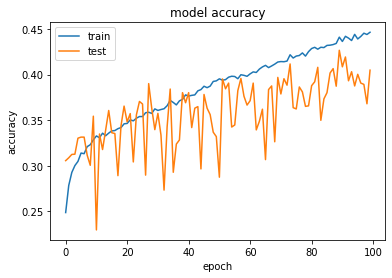

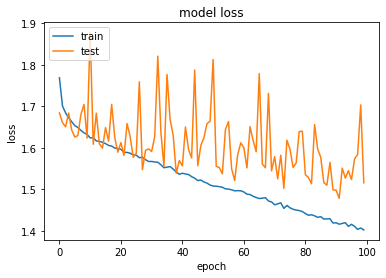

In [14]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
emotion_count = dev_dataset['emotion'].value_counts()
emotion_count.index = emotion_count.index.map(int_to_emotion)
print("Distribution count of emotions in the dataset:")
print(emotion_count)

Distribution count of emotions in the dataset:
Happy       895
Sad         653
Neutral     607
Fear        496
Angry       467
Surprise    415
Name: emotion, dtype: int64


In [16]:
#model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Emotion Recognition/Model/resnet50_sgd.h5')